# [LVV-T2214] _ Plots

This notebook will analyze the data from LVV-T2214 test case. 

[lsst-ts/ts_notebooks]: https://github.com/lsst-ts/ts_notebooks/blob/develop/bxin/aos2comp/aos2comp.ipynb
[LVV-T2214]: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T2214

## Requirements

This notebooks require some extra repositories to be installed locally so it can grab some constants and some look-up tables.  
Here is a list of which repos are these:

* [lsst-ts/ts_cRIOpy]

[lsst-ts/ts_cRIOpy]: https://github.com/lsst-ts/ts_cRIOpy 
[lsst-ts/ts_m1m3support]: https://github.com/lsst-ts/ts_m1m3support

To install them, open a terminal and run the following commands:

```
git clone https://github.com/lsst-ts/ts_cRIOpy $HOME/notebooks/lsst-ts/ts_cRIOpy
git clone https://github.com/lsst-ts/ts_m1m3support.git $HOME/notebooks/lsst-ts/ts_m1m3support
git clone https://github.com/lsst-ts/ts_config_mttcs $HOME/notebooks/lsst-ts/ts_config_mttcs
git clone https://github.com/lsst-sitcom/M2_FEA $HOME/notebooks/lsst-sitcom/M2_FEA
```

And add these lines to your `$HOME/notebooks/.user_setup` file: 

```
setup -j notebooks_vandv -r ~/notebooks/lsst-sitcom/notebooks_vandv
setup -j ts_cRIOpy -r $HOME/notebooks/lsst-ts/ts_cRIOpy
```

In [168]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
from lsst.sitcom import vandv

exec_info = vandv.()
print(exec_info)

SyntaxError: invalid syntax (1887280129.py, line 3)

---
## Initialization

- Import all libraries
- Get the remotes ready

In [4]:
import asyncio
import os
import yaml

import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from astropy.time import Time, TimeDelta
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
from datetime import datetime, timedelta

import lsst_efd_client 

from lsst.ts.cRIOpy import M1M3FATable


In [5]:
test_execution = "LVV-D220704"

In [6]:
log = logging.getLogger("LVV-T2214")
log.setLevel(logging.DEBUG)

In [7]:
lsst_efd_client.EfdClient.list_efd_names()

['ldf_int_efd',
 'base_efd',
 'tucson_teststand_efd',
 'test_efd',
 'summit_efd',
 'ncsa_teststand_efd',
 'ldf_stable_efd']

In [171]:
#efd_name = "summit_efd"
location = "summit"

if location == "summit":
    client = lsst_efd_client.EfdClient("summit_efd")
elif location == "tucson":
    client = lsst_efd_client.EfdClient("tucson_teststand_efd")
else:
    raise ValueError(
        "Location does not match any valid options {summit|tucson}"
        )

In [9]:
client = lsst_efd_client.EfdClient(efd_name)

In [10]:
os.makedirs("plots", exist_ok=True)

## Define time windows for the test execution 
    Gathering data - without Aberrations - Start time: 2022-06-21T00:36:46.077
    Gathering data - without Aberrations - End time: 2022-06-21T00:41:25.742

    Gathering data - with Aberrations (reset every time) - Start time: 2022-06-21T01:51:30.700
    Gathering data - with Aberrations (reset every time) - End time: 2022-06-21T01:56:32.971

    Gathering data - with Aberrations Accumulated - Start time: 2022-06-21T01:57:36.178
    Gathering data - with Aberrations Accumulated - End time: 2022-06-21T02:02:26.898

In [32]:
# Without aberrations
t_start = "2022-06-21T00:36:46.077"
t_start = Time(t_start, format="isot", scale="utc")

t_end = "2022-06-21T00:41:25.742"
t_end = Time(t_end, format="isot", scale="utc")

In [33]:
# With aberrations (Reset every time)
t_start_aberr = "2022-06-21T01:51:30.700"
t_start_aberr = Time(t_start_aberr, format="isot", scale="utc")

t_end_aberr = "2022-06-21T01:56:32.971"
t_end_aberr = Time(t_end_aberr, format="isot", scale="utc")

In [34]:
# With aberrations (Accumulated)
t_start_aberr_accum = "2022-06-21T01:57:36.178"
t_start_aberr_accum = Time(t_start_aberr_accum, format="isot", scale="utc")

t_end_aberr_accum = "2022-06-21T02:02:26.898"
t_end_aberr_accum = Time(t_end_aberr_accum, format="isot", scale="utc")

## Helper Functions

In [14]:
async def get_data_from_efd(location, start, end):
    """
    Retrieves data relevant for analysis.
    
    Parameters
    ----------
    location : str
        In which Test Stand are you running this test?
    start : str or datetime
        Start of the time-window.
    end : str or datetime 
        End of the time-window.
    """
    if location == "summit":
        client = lsst_efd_client.EfdClient("summit_efd")
    elif location == "tucson":
        client = lsst_efd_client.EfdClient("tucson_teststand_efd")
    else:
        raise ValueError(
            "Location does not match any valid options {summit|tucson}"
        )
    
    _df_mount_el = await client.select_time_series(
        "lsst.sal.MTMount.elevation", 
        fields="actualPosition", 
        start=start, 
        end=end,
    )
    
    _df_m1m3_101 = await client.select_time_series(
        "lsst.sal.MTM1M3.forceActuatorData",
        fields="zForce101",
        start=start, 
        end=end,
    )
        
    # M2 B1?
    _df_m2 = await client.select_time_series(
        "lsst.sal.MTM2.axialForce",
        fields=[
            "applied0",
            "lutGravity0",
            "measured0"
        ],
        start=start, 
        end=end,
    )
    
    # CamHex Y position
    _df_camhex = await client.select_time_series(
        "lsst.sal.MTHexapod.application",
        fields=[
            "position1"
        ],
        index=1,
        start=start, 
        end=end,
    )
    
    # M2Hex Y position
    _df_m2hex = await client.select_time_series(
        "lsst.sal.MTHexapod.application",
        fields=[
            "position1"
        ],
        index=2,
        start=start, 
        end=end,
    )

    # Rename columns
    _df_mount_el.rename(columns={"actualPosition": "mount_el"}, inplace=True)
    _df_m1m3_101.rename(columns={"zForce101": "m1m3_z101"}, inplace=True)
    _df_m2.rename(columns={"applied0": "m2b1_applied", "lutGravity0": "m2b1_gravLut", "measured0": "m2b1_measured"}, inplace=True)
    _df_camhex.rename(columns={"position1": "camhex_y"}, inplace=True)
    _df_m2hex.rename(columns={"position1": "m2hex_y"}, inplace=True)

    
    # Join dataframes
    _df = _df_mount_el
    
    _df = pd.merge(
        _df, 
        _df_m1m3_101, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )
         
    _df = pd.merge(
        _df, 
        _df_m2, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )
    
    _df = pd.merge(
        _df, 
        _df_camhex, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )

    _df = pd.merge(
        _df, 
        _df_m2hex, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )
    
    return _df

In [192]:
async def get_track_info(start_time, end_time):
    
    moveToTarget_times = []
    
    startTracking_times = await client.select_time_series(
        'lsst.sal.MTMount.command_startTracking', 
        ['*'], 
        start_time, 
        end_time
    )

    stopTracking_times = await client.select_time_series(
        'lsst.sal.MTMount.command_stopTracking', 
        ['*'], 
        start_time, 
        end_time
    )

    _move = await client.select_time_series(
        'lsst.sal.MTMount.command_moveToTarget', 
        ['*'], 
        start_time, 
        end_time
    )

    #tracks = [0,1,2,3]    

    for track in tracks:
        # Find first the time of the first moveToTarget command for each slew
        if track ==0:
            move_time = _move[(_move.index <= startTracking_times.index[track])].index[0]
        else: 
            move_time = _move[(_move.index >= stopTracking_times.index[track-1]) 
                                        & (_move.index <= startTracking_times.index[track])].index[0]
        
        moveToTarget_times.append(move_time)
        
    return startTracking_times, stopTracking_times, moveToTarget_times

In [183]:
uno, dos, tres = await get_track_info(t_start, t_end)

In [188]:
tres

[Timestamp('2022-06-21 00:36:46.078000+0000', tz='UTC'),
 Timestamp('2022-06-21 00:38:06.074000+0000', tz='UTC'),
 Timestamp('2022-06-21 00:39:14.074000+0000', tz='UTC'),
 Timestamp('2022-06-21 00:40:19.958000+0000', tz='UTC')]

In [204]:
async def get_forces_and_positions(moveToTarget_times):
    """
    Retrieves M1M3 and M2 forces, along with Cam and M2 Hexapods positions, in the [1.5-0.5] sec interval 
    between the ATAOS corrections are issued and the mount is commanded to the next source.
    
    Parameters
    ----------
    moveToTarget_times : list of timestamps 
        Returned from get_track_info() function.
        
    """

    #tracks = [0,1,2,3]  
    t_before = 1.5
    t_after = 0.5
    
    #df_names = ['df_m1m3', 'df_m2', 'df_camhex', 'df_m2hex']
    df_m1m3 = pd.DataFrame()
    df_m2 = pd.DataFrame()
    df_camhex = pd.DataFrame()
    df_m2hex = pd.DataFrame()
    
    for track in tracks:
        
        # Query m1m3 forces between 1.5 and 0.5 seconds before the move command was issued (or 0.5 and 1.5 seconds
        # after correction is issued. 
        _df_m1m3_forces = await client.select_time_series(
            "lsst.sal.MTM1M3.forceActuatorData",
            fields=[f"zForce{i}" for i in range(156)],        
            start=Time(moveToTarget_times[track]) - TimeDelta(t_before, format='sec'), 
            end=Time(moveToTarget_times[track])- TimeDelta(t_after,format='sec')
        )
        _df_m1m3_mean = _df_m1m3_forces.mean()
        
        df_m1m3 = df_m1m3.append(_df_m1m3_mean, ignore_index=True)

        # Query M2 forces
        _df_m2_forces = await client.select_time_series(
            "lsst.sal.MTM2.axialForce",
            [f"measured{i}" for i in range(72)], 
            start=Time(moveToTarget_times[track]) - TimeDelta(2.2, format='sec'), 
            end=Time(moveToTarget_times[track])- TimeDelta(0.2,format='sec')
        )
        _df_m2_mean = _df_m2_forces.mean()  
        
        df_m2 = df_m2.append(_df_m2_mean, ignore_index=True)
        
        # Cam Hex
        _df_camhex_positions = await client.select_time_series(
            "lsst.sal.MTHexapod.application",
            fields=["position0", "position1", "position2"],
            start=Time(moveToTarget_times[track]) - TimeDelta(t_before, format='sec'), 
            end=Time(moveToTarget_times[track])- TimeDelta(t_after,format='sec'),
            index=1
        )
        
        _df_camhex_positions.rename(columns={'position0':'x', 
                                             'position1':'y', 
                                             'position2':'z'}, 
                                    inplace=True)

        _df_camhex_mean = _df_camhex_positions.mean()
        
        df_camhex = df_camhex.append(_df_camhex_mean,ignore_index=True)
        
        # M2 Hex
        _df_m2hex_positions = await client.select_time_series(
            "lsst.sal.MTHexapod.application",
            fields=["position0", "position1", "position2"],
            start=Time(moveToTarget_times[track]) - TimeDelta(t_before, format='sec'), 
            end=Time(moveToTarget_times[track])- TimeDelta(t_after,format='sec'),
            index=2
        )
        
        _df_m2hex_positions.rename(columns={'position0':'x', 
                                             'position1':'y', 
                                             'position2':'z'}, 
                                    inplace=True)
        
        _df_m2hex_mean = _df_m2hex_positions.mean()
        
        df_m2hex = df_m2hex.append(_df_m2hex_mean,ignore_index=True)
        
    return df_m1m3, df_m2, df_camhex, df_m2hex

## Define tracks and get information for each track (MoveToTarget, StartTracking, StopTracking)

In [190]:
tracks = [0,1,2,3]
aberrations = ['Focus', 'Astigmatism', 'Coma', 'Trefoil']

In [193]:
startTracking_without, stopTracking_without, move_without = await get_track_info(t_start, t_end)
startTracking_withaberr, stopTracking_withaberr, move_withaberr = await get_track_info(t_start_aberr, t_end_aberr)
startTracking_aberr_accum, stopTracking_aberr_accum, move_aberr_accum = await get_track_info(t_start_aberr_accum, t_end_aberr_accum)

In [227]:
startTracking_without

,private_efdStamp,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp
2022-06-21 00:37:22.989000+00:00,1.655772e+09,MTMount,1.655772e+09,18888,1.655772e+09,1b82ebd6,1656036808,1.655772e+09
2022-06-21 00:38:29.073000+00:00,1.655772e+09,MTMount,1.655772e+09,18888,1.655772e+09,1b82ebd6,1656036809,1.655772e+09
2022-06-21 00:39:36.958000+00:00,1.655772e+09,MTMount,1.655772e+09,18888,1.655772e+09,1b82ebd6,1656036810,1.655772e+09
2022-06-21 00:40:42.741000+00:00,1.655772e+09,MTMount,1.655772e+09,18888,1.655772e+09,1b82ebd6,1656036811,1.655772e+09


In [225]:
move = await client.select_time_series(
        'lsst.sal.MTMount.command_moveToTarget', 
        ['*'], 
        t_start, 
        t_end
    )

## Plot optics vs time for each slew. 

In [65]:
# Query telemetry

df_without = await get_data_from_efd(
    location, 
    t_start, 
    t_end)

#df_without.index= (df_without.index) - (df_without.index[0])

df_aberr = await get_data_from_efd(
    location, 
    t_start_aberr, 
    t_end_aberr)

#df_aberr.index = df_aberr.index - df_aberr.index[0]

df_aberr_acc = await get_data_from_efd(
    location, 
    t_start_aberr_accum, 
    t_end_aberr_accum)

#df_aberr_acc.index = df_aberr_acc.index - df_aberr_acc.index[0]

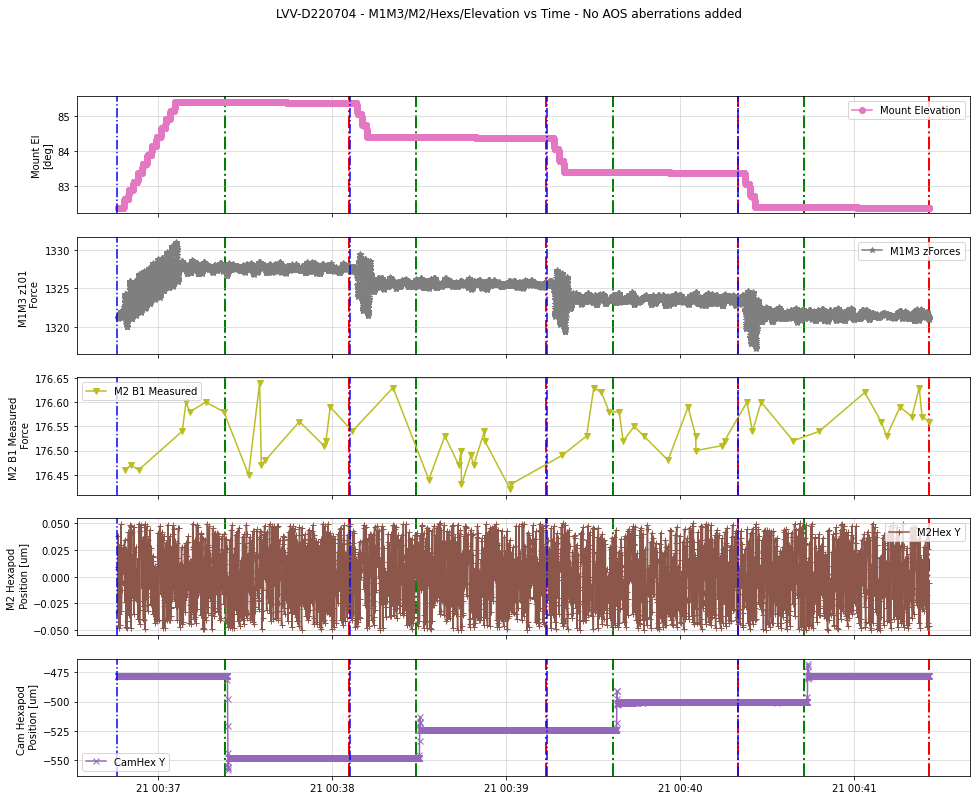

In [224]:
# Without aberrations
fig, axs = plt.subplots(figsize=(16, 12.5), nrows=5, sharex=True)

axs[0].plot(df_without["mount_el"].dropna(), "C6o-", label="Mount Elevation")
axs[0].set_ylabel("Mount El\n[deg]")

    
axs[1].plot(df_without["m1m3_z101"].dropna(), "C7*-", label="M1M3 zForces")
axs[1].set_ylabel("M1M3 z101 \n Force")

# 
axs[2].plot(df_without["m2b1_measured"].dropna(), "C8v-", label="M2 B1 Measured")
axs[2].set_ylabel("M2 B1 Measured \n Force")

axs[3].plot(df_without["m2hex_y"].dropna(), "C5+-", label="M2Hex Y")
axs[3].set_ylabel("M2 Hexapod \n Position [um]")


axs[4].plot(df_without["camhex_y"].dropna(), "C4x-", label="CamHex Y")
axs[4].set_ylabel("Cam Hexapod \n Position [um]")

for ax in axs:
    ax.grid(":", alpha=0.5)
    ax.legend()
    for k in np.arange(len(startTracking_without)):
        ax.axvline(x=startTracking_without.index[k],c="green",linewidth=2,zorder=0, clip_on=False, ls = "-.")
        ax.axvline(x=stopTracking_without.index[k],c="red",linewidth=2, zorder=0,clip_on=False, ls = "-.")
        ax.axvline(x=(move_without[k]), c="blue", ls = "-.")
    
# Plot vertical lines for Start and Stop Tracking, MoveToTarget.


fig.suptitle(f"{test_execution} - M1M3/M2/Hexs/Elevation vs Time - No AOS aberrations added")
#fig.tight_layout(h_pad=0.5)
fig.patch.set_facecolor('white')   

#fig.savefig(f"plots/{test_execution}_m1m3_m2_hexs_el_vs_time_without.png")
plt.show()

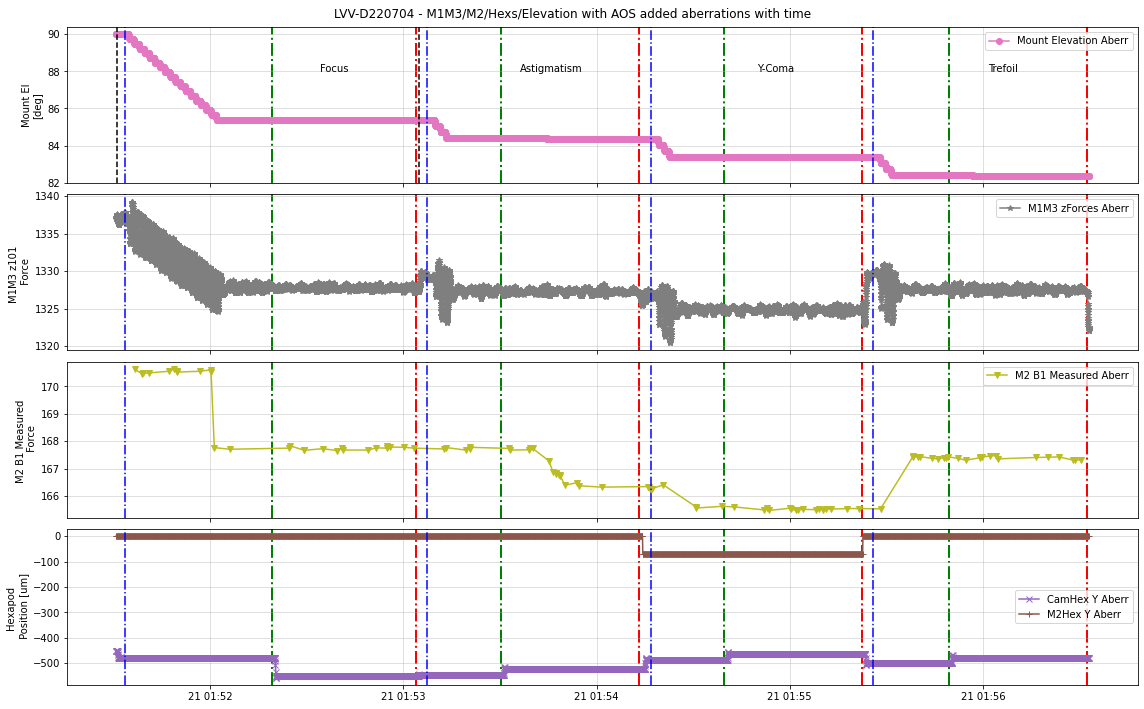

In [222]:
# With aberrations (Reset every time)

fig, axs = plt.subplots(figsize=(16, 10), nrows=4, sharex=True)

axs[0].plot(df_aberr["mount_el"].dropna(), "C6o-", label="Mount Elevation Aberr")
axs[0].set_ylabel("Mount El\n[deg]")

axs[0].axvline(m1m3_correction.index[0], c='black', ls="--")
axs[0].axvline(m1m3_correction.index[2], c='black', ls="--")
axs[0].text(startTracking_withaberr.index[0]+timedelta(seconds=15), 88, 'Focus')
axs[0].text(startTracking_withaberr.index[1]+timedelta(seconds=6), 88, 'Astigmatism')
axs[0].text(startTracking_withaberr.index[2]+timedelta(seconds=10), 88, 'Y-Coma')
axs[0].text(startTracking_withaberr.index[3]+timedelta(seconds=12), 88, 'Trefoil')


axs[1].plot(df_aberr["m1m3_z101"].dropna(), "C7*-", label="M1M3 zForces Aberr")
axs[1].set_ylabel("M1M3 z101 \n Force")

axs[2].plot(df_aberr["m2b1_measured"].dropna(), "C8v-", label="M2 B1 Measured Aberr")
axs[2].set_ylabel("M2 B1 Measured \n Force")

axs[3].plot(df_aberr["camhex_y"].dropna(), "C4x-", label="CamHex Y Aberr")
axs[3].plot(df_aberr["m2hex_y"].dropna(), "C5+-", label="M2Hex Y Aberr")
axs[3].set_ylabel("Hexapod \n Position [um]")

for ax in axs:
    ax.grid(":", alpha=0.5)
    ax.legend()
    for k in np.arange(len(startTracking_withaberr)):
        ax.axvline(x=startTracking_withaberr.index[k],c="green",linewidth=2,zorder=0, clip_on=False, ls = "-.")
        ax.axvline(x=stopTracking_withaberr.index[k],c="red",linewidth=2, zorder=0,clip_on=False, ls = "-.")
        ax.axvline(x=(move_withaberr[k]), c="blue", ls = "-.")

fig.suptitle(f"{test_execution} - M1M3/M2/Hexs/Elevation with AOS added aberrations with time")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')   

fig.savefig(f"plots/{test_execution}_m1m3_m2_hexs_el_vs_time_with_aberr.png")
plt.show()

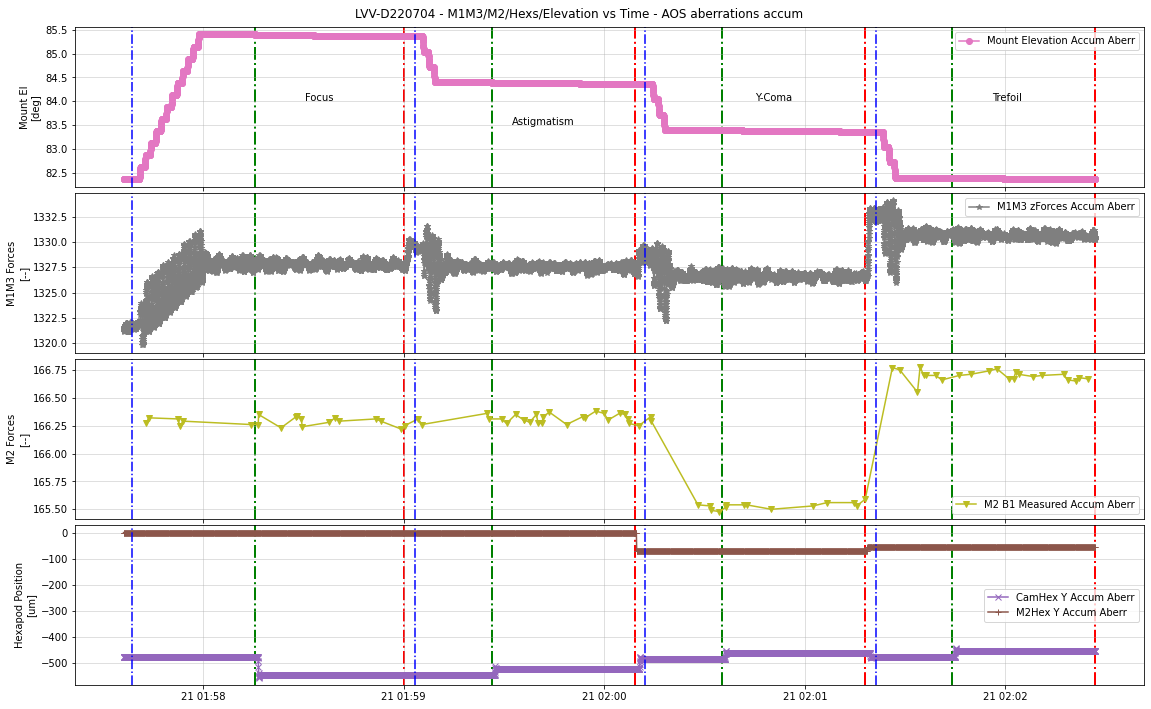

In [223]:
# With aberrations (Accumulated)
fig, axs = plt.subplots(figsize=(16, 10), nrows=4, sharex=True)

axs[0].plot(df_aberr_acc["mount_el"].dropna(), "C6o-", label="Mount Elevation Accum Aberr")
axs[0].set_ylabel("Mount El\n[deg]")

axs[0].text(startTracking_aberr_accum.index[0]+timedelta(seconds=15), 84, 'Focus')
axs[0].text(startTracking_aberr_accum.index[1]+timedelta(seconds=6), 83.5, 'Astigmatism')
axs[0].text(startTracking_aberr_accum.index[2]+timedelta(seconds=10), 84, 'Y-Coma')
axs[0].text(startTracking_aberr_accum.index[3]+timedelta(seconds=12), 84, 'Trefoil')

    
axs[1].plot(df_aberr_acc["m1m3_z101"].dropna(), "C7*-", label="M1M3 zForces Accum Aberr")
axs[1].set_ylabel("M1M3 Forces\n[--]")

axs[2].plot(df_aberr_acc["m2b1_measured"].dropna(), "C8v-", label="M2 B1 Measured Accum Aberr")
axs[2].set_ylabel("M2 Forces\n[--]")

axs[3].plot(df_aberr_acc["camhex_y"].dropna(), "C4x-", label="CamHex Y Accum Aberr")
axs[3].plot(df_aberr_acc["m2hex_y"].dropna(), "C5+-", label="M2Hex Y Accum Aberr")
axs[3].set_ylabel("Hexapod Position\n[um]")

for ax in axs:
    ax.grid(":", alpha=0.5)
    ax.legend()
    for k in np.arange(len(startTracking_aberr_accum)):
        ax.axvline(x=startTracking_aberr_accum.index[k],c="green",linewidth=2,zorder=0, clip_on=False, ls = "-.")
        ax.axvline(x=stopTracking_aberr_accum.index[k],c="red",linewidth=2, zorder=0,clip_on=False, ls = "-.")
        ax.axvline(x=(move_aberr_accum[k]), c="blue", ls = "-.")

fig.suptitle(f"{test_execution} - M1M3/M2/Hexs/Elevation vs Time - AOS aberrations accum")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')   

fig.savefig(f"plots/{test_execution}_m1m3_m2_hexs_el_vs_time_with_aberr_accum.png")
plt.show()

## Compare against the corrections sent by MTAOS. 

check the force and hexapod position differences between steps 10 and 12.

Compare against the corrections sent by MTAOS. They should match.

In [205]:
# First get the forces and hexapod positions approx 1 second before moving to target in each track with 
# and without aberrations. 
m1m3_withaberr, m2_withaberr, camhex_withaberr, m2hex_withaberr = await get_forces_and_positions(move_withaberr)
m1m3_without, m2_without, camhex_without, m2hex_without = await get_forces_and_positions(move_without)

/tmp/ipykernel_45372/3880081880.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_m1m3 = df_m1m3.append(_df_m1m3_mean, ignore_index=True)
/tmp/ipykernel_45372/3880081880.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_m2 = df_m2.append(_df_m2_mean, ignore_index=True)
/tmp/ipykernel_45372/3880081880.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_camhex = df_camhex.append(_df_camhex_mean,ignore_index=True)
/tmp/ipykernel_45372/3880081880.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_m2hex = df_m2hex.append(_df_m2hex_mean,ignore_index=True)
/tmp/ipykernel_45372/3880081880.py:35: FutureWarning: The frame.app

### M1 forces vs MTAOS corrections

In [206]:
m1m3_correction = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_m1m3Correction', 
    [f"zForces{i}" for i in range(156)],       
    t_start_aberr, 
    t_end_aberr
)
m1m3_correction.columns = m1m3_correction.columns.str.replace('zForces', 'zForce')

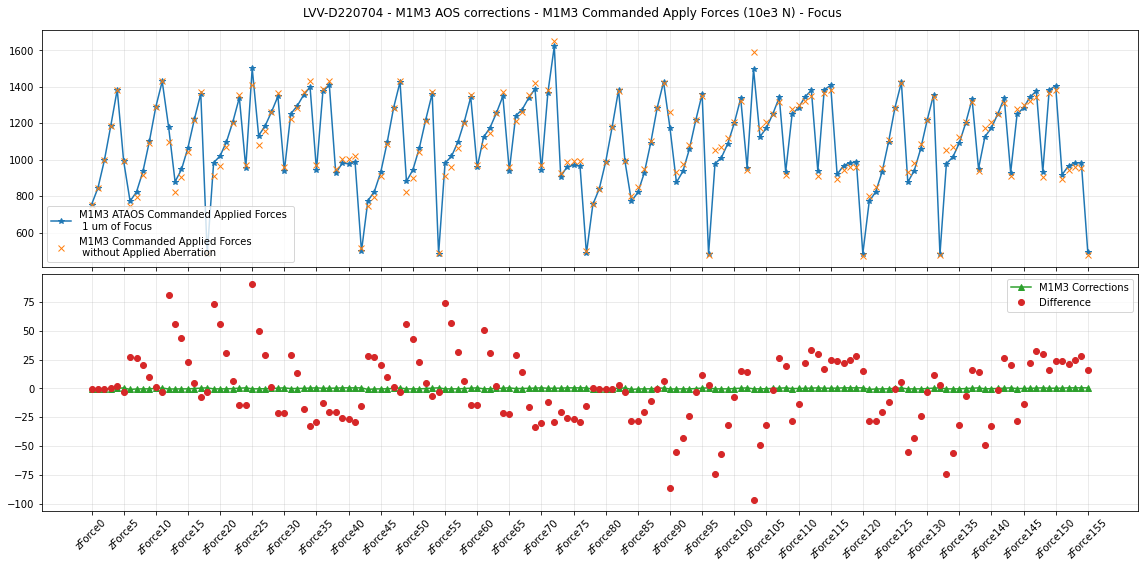

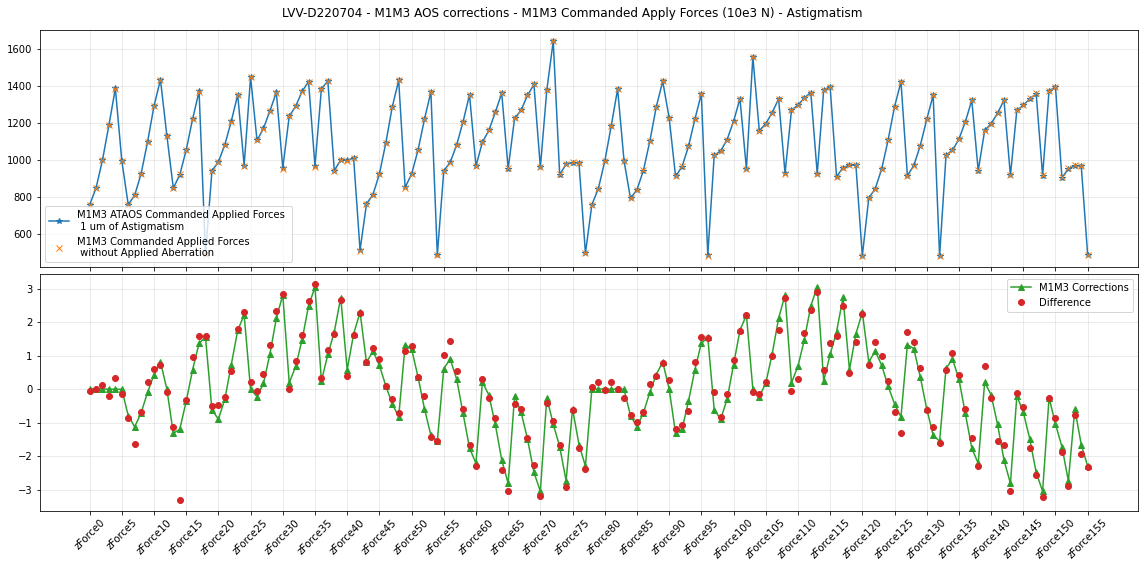

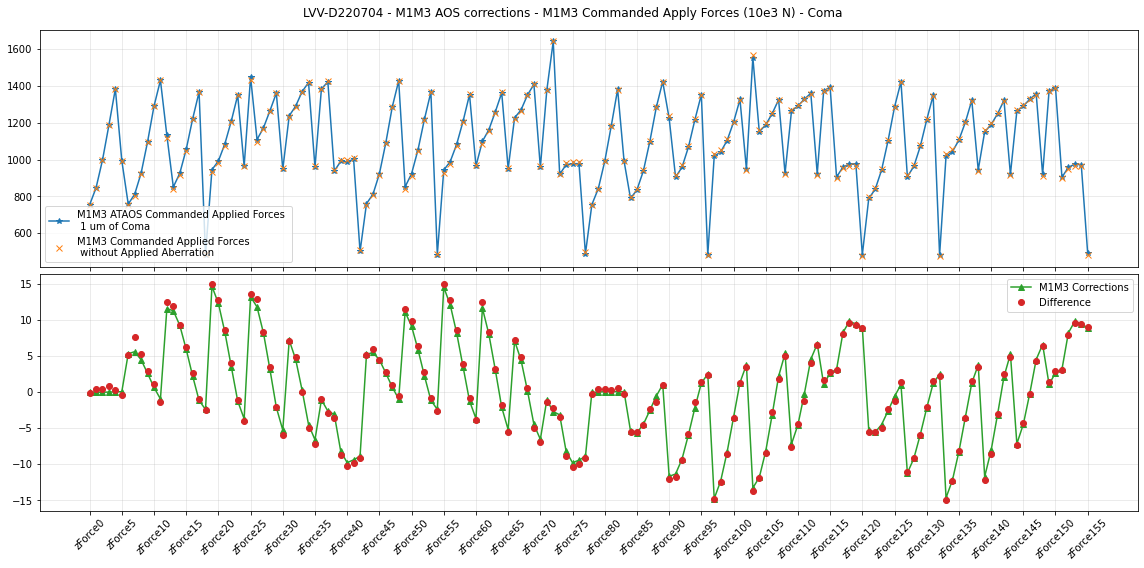

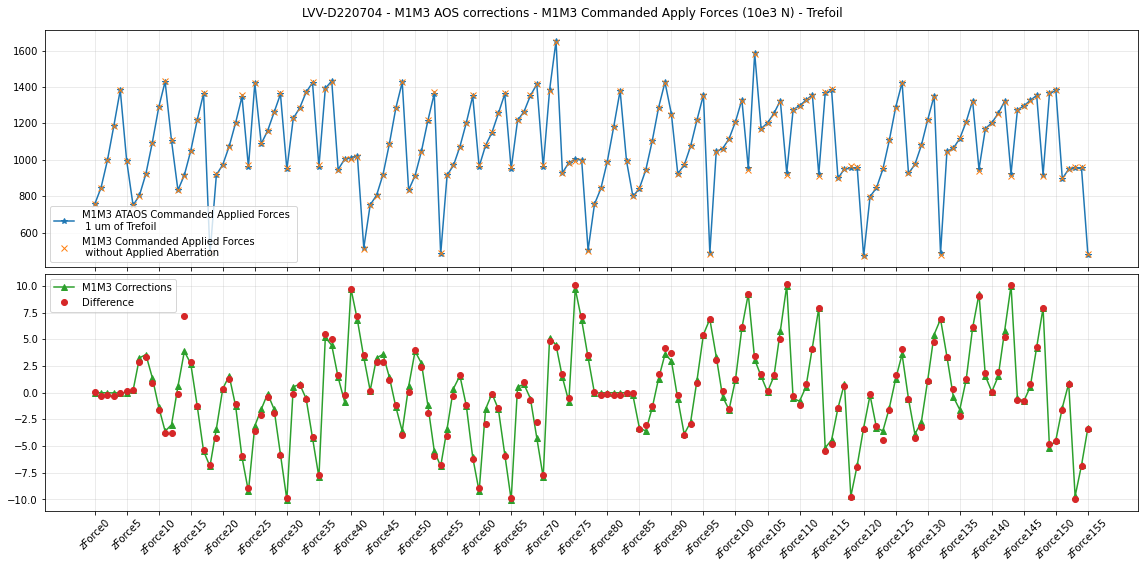

In [207]:
for track,aberr in zip(tracks,aberrations):

    fig, axs = plt.subplots(2,1, figsize=(16, 8), sharex=True)

    axs[0].plot(m1m3_withaberr.iloc[track], "C0*-", label=f"M1M3 ATAOS Commanded Applied Forces \n 1 um of {aberr}")
    axs[0].plot(m1m3_without.iloc[track], "C1x", label="M1M3 Commanded Applied Forces \n without Applied Aberration")

    axs[1].plot(m1m3_correction.iloc[track*2], "C2^-", label="M1M3 Corrections")
    axs[1].plot(m1m3_withaberr.iloc[track]-m1m3_without.iloc[track], "C3o", label="Difference")

    for ax in axs.flat:
        ax.grid(":", alpha=0.3)
        ax.legend()
        ax.xaxis.set_ticks(np.arange(0, 156, 5))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            
    fig.suptitle(f"{test_execution} - M1M3 AOS corrections - M1M3 Commanded Apply Forces (10e3 N) - {aberr}")
    fig.tight_layout(h_pad=0.3)
    fig.patch.set_facecolor('white')   

    fig.savefig(f"plots/{test_execution}_m1m3_forces_vs_aos_corrections_{aberr}.png")
    plt.show()

We compare numerically zForce101. 

In [208]:
# Print force differences between aberr and nonaberr tracks vs MTAOS corrections for each type of aberration

for track,aberr in zip(tracks,aberrations):
    print(f"###################    1 um of {aberr}    ###################")
    print(f"zForce101_diff    \t \n"
          f"{m1m3_withaberr.iloc[track].zForce101-m1m3_without.iloc[track].zForce101:0.5f}     \n"
          f"zForce101_corr    \t Time  ---- MTAOS correction \n"
          f"{m1m3_correction.iloc[track*2].zForce101:0.5f} \t {m1m3_correction.index[track*2]} \n")

###################    1 um of Focus    ###################
zForce101_diff    	 
15.38336     
zForce101_corr    	 Time  ---- MTAOS correction 
0.21455 	 2022-06-21 01:51:30.892000+00:00 

###################    1 um of Astigmatism    ###################
zForce101_diff    	 
1.74020     
zForce101_corr    	 Time  ---- MTAOS correction 
1.75766 	 2022-06-21 01:53:04.778000+00:00 

###################    1 um of Coma    ###################
zForce101_diff    	 
1.31782     
zForce101_corr    	 Time  ---- MTAOS correction 
1.30584 	 2022-06-21 01:54:14.278000+00:00 

###################    1 um of Trefoil    ###################
zForce101_diff    	 
6.18543     
zForce101_corr    	 Time  ---- MTAOS correction 
6.05188 	 2022-06-21 01:55:23.292000+00:00 



### M2 forces vs MTAOS corrections

In [101]:
m2_correction = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_m2Correction', 
    [f"zForces{i}" for i in range(72)], 
    t_start_aberr, 
    t_end_aberr
)
# Change column names to match that of commanded forces, aka axial. 
m2_correction.columns = m2_correction.columns.str.replace("zForces", "measured")

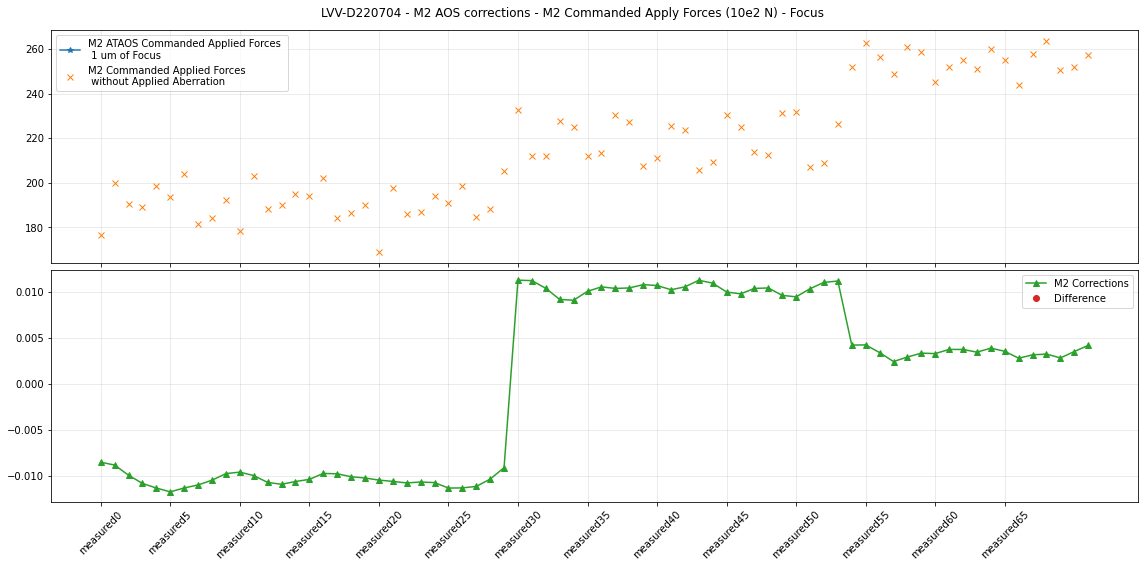

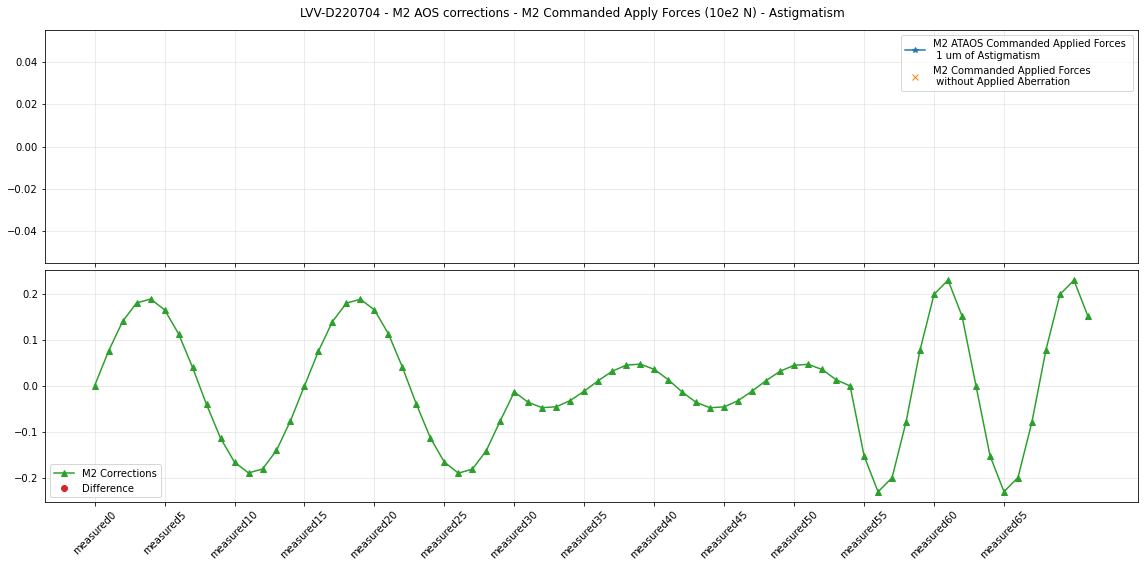

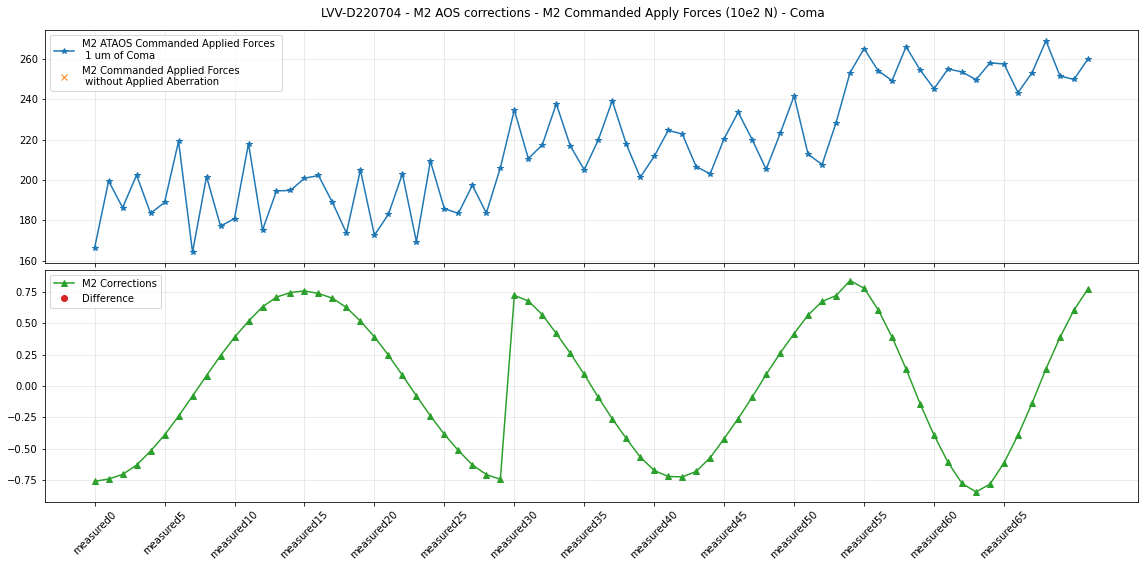

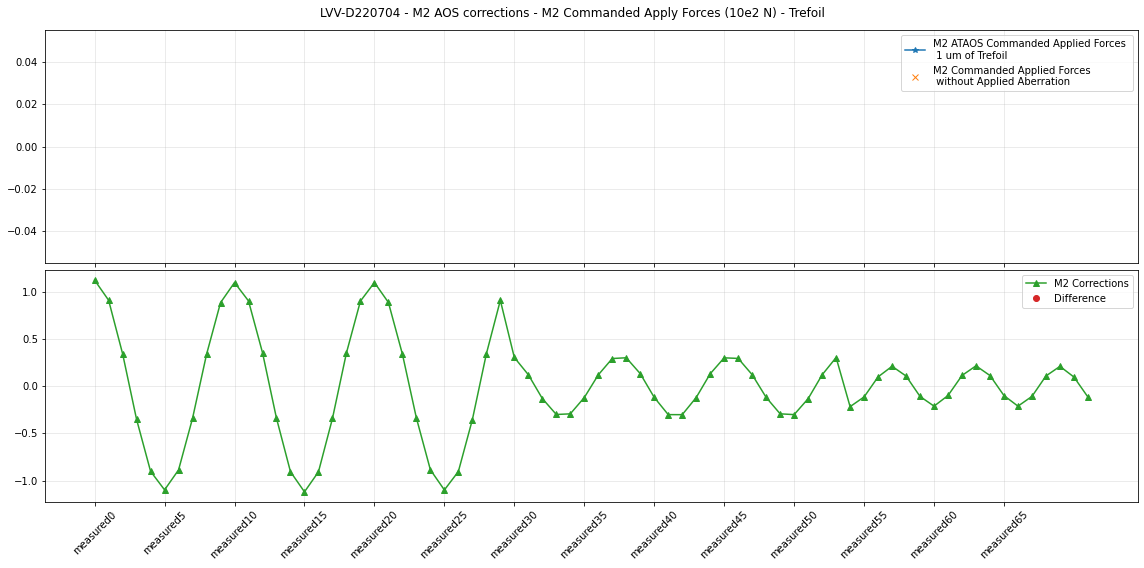

In [170]:
for track,aberr in zip(tracks,aberrations):

    fig, axs = plt.subplots(2,1, figsize=(16, 8), sharex=True)

    axs[0].plot(m2_withaberr.iloc[track], "C0*-", label=f"M2 ATAOS Commanded Applied Forces \n 1 um of {aberr}")
    axs[0].plot(m2_without.iloc[track], "C1x", label="M2 Commanded Applied Forces \n without Applied Aberration")

    axs[1].plot(m2_correction.iloc[track*2], "C2^-", label="M2 Corrections")
    axs[1].plot(m2_withaberr.iloc[track]-m2_without.iloc[track], "C3o", label="Difference")

    for ax in axs.flat:
        ax.grid(":", alpha=0.3)
        ax.legend()
        ax.xaxis.set_ticks(np.arange(0, 70, 5))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            
    fig.suptitle(f"{test_execution} - M2 AOS corrections - M2 Commanded Apply Forces (10e2 N) - {aberr}")
    fig.tight_layout(h_pad=0.3)
    fig.patch.set_facecolor('white')   

    fig.savefig(f"plots/{test_execution}_m2_forces_vs_aos_corrections_{aberr}.png")
    plt.show()

In [136]:
# Print force differences between aberr and nonaberr tracks vs MTAOS corrections for each type of aberration

for track,aberr in zip(tracks,aberrations):
    print(f"###################    1 um of {aberr}    ###################")
    print(f"m2B1_measured_diff    \t \n"
          f"{m2_withaberr.iloc[track].measured0-m2_without.iloc[track].measured0:0.5f}     \n"
          f"zForce101_corr    \t Time  ---- MTAOS correction \n"
          f"{m2_correction.iloc[track*2].measured0:0.5f} \t {m2_correction.index[track*2]} \n")

###################    1 um of Focus    ###################
m2B1_measured_diff    	 
nan     
zForce101_corr    	 Time  ---- MTAOS correction 
-0.00852 	 2022-06-21 01:51:30.893000+00:00 

###################    1 um of Astigmatism    ###################
m2B1_measured_diff    	 
nan     
zForce101_corr    	 Time  ---- MTAOS correction 
0.00043 	 2022-06-21 01:53:04.779000+00:00 

###################    1 um of Coma    ###################
m2B1_measured_diff    	 
nan     
zForce101_corr    	 Time  ---- MTAOS correction 
-0.75919 	 2022-06-21 01:54:14.278000+00:00 

###################    1 um of Trefoil    ###################
m2B1_measured_diff    	 
nan     
zForce101_corr    	 Time  ---- MTAOS correction 
1.12242 	 2022-06-21 01:55:23.294000+00:00 



### CamHex vs MTAOS corrections

In [152]:
# Get the MTAOS corrections 
cam_hexapod_correction_applied_xyz = await client.select_time_series(
    'lsst.sal.MTHexapod.logevent_uncompensatedPosition', 
    ["x", "y", "z"], 
    t_start_aberr, 
    t_end_aberr,
    index=1
)

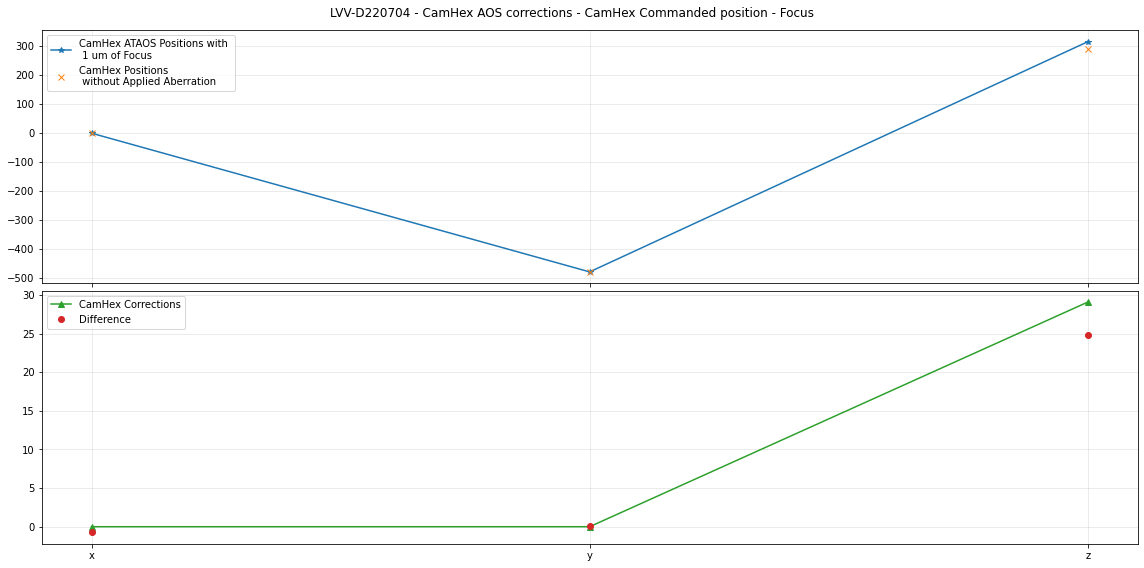

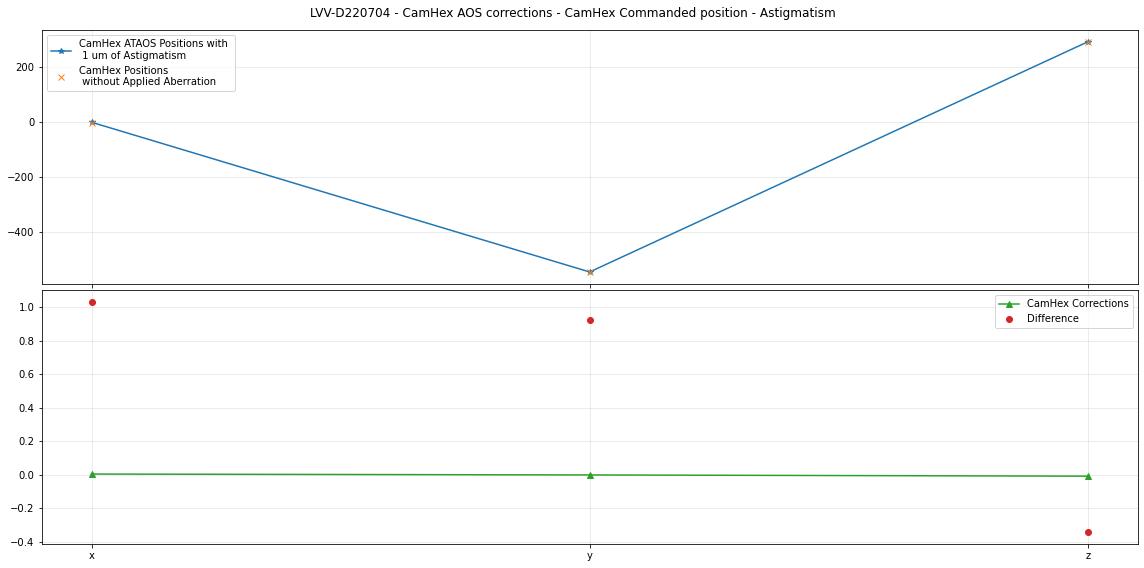

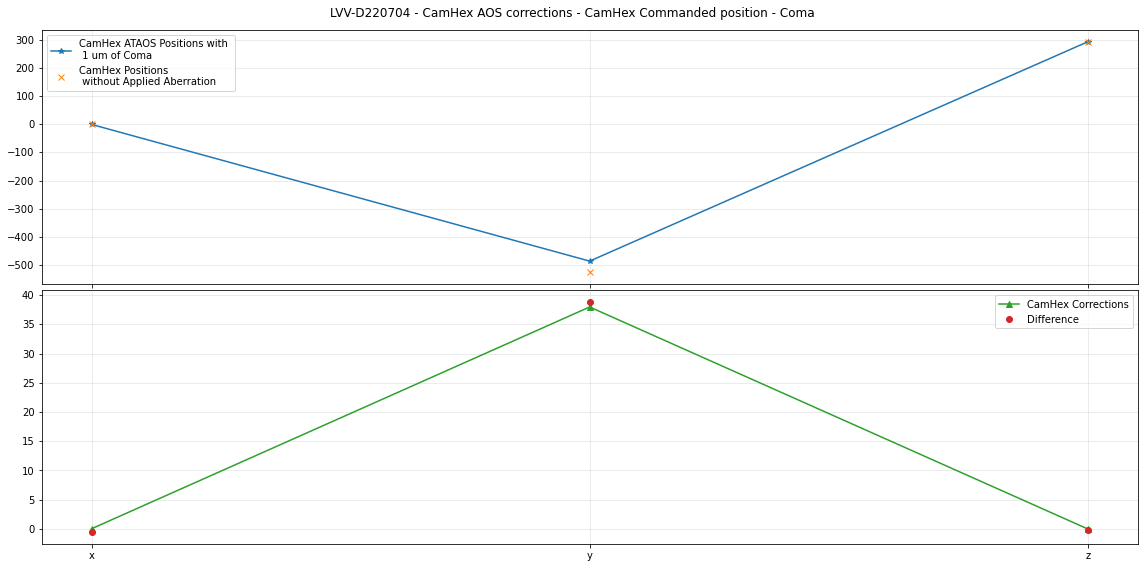

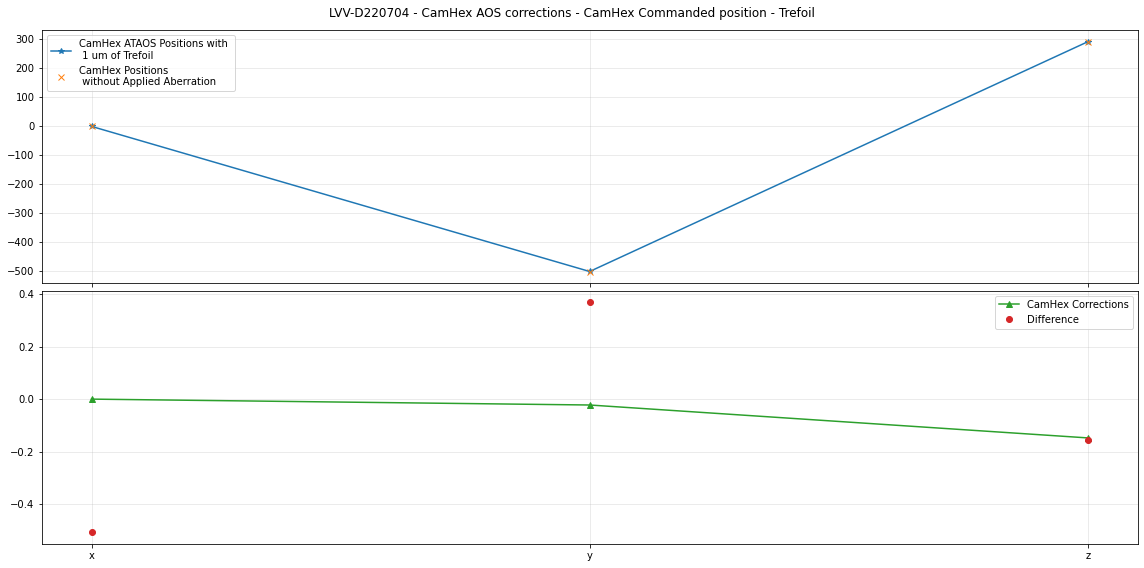

In [153]:
for track,aberr in zip(tracks,aberrations):

    fig, axs = plt.subplots(2,1, figsize=(16, 8), sharex=True)

    axs[0].plot(camhex_withaberr.iloc[track], "C0*-", label=f"CamHex ATAOS Positions with \n 1 um of {aberr}")
    axs[0].plot(camhex_without.iloc[track], "C1x", label="CamHex Positions \n without Applied Aberration")

    axs[1].plot(cam_hexapod_correction_applied_xyz.iloc[track*2], "C2^-", label="CamHex Corrections")
    axs[1].plot(camhex_withaberr.iloc[track]-camhex_without.iloc[track], "C3o", label="Difference")

    for ax in axs.flat:
        ax.grid(":", alpha=0.3)
        ax.legend()
        ax.xaxis.set_ticks(np.arange(0, 3, 1))
         
    fig.suptitle(f"{test_execution} - CamHex AOS corrections - CamHex Commanded position - {aberr}")
    fig.tight_layout(h_pad=0.3)
    fig.patch.set_facecolor('white')   

    fig.savefig(f"plots/{test_execution}_camhex_vs_aos_corrections_{aberr}.png")
    plt.show()

In [154]:
# Print position differences between aberr and nonaberr tracks vs MTAOS corrections for each type of aberration

for track,aberr in zip(tracks,aberrations):
    print(f"###################    1 um of {aberr}    ###################")
    print(f"y_diff    \t \n"
          f"{camhex_withaberr.iloc[track].y-camhex_without.iloc[track].y:0.5f}     \n"
          f"y_corr    \t Time  ---- MTAOS correction \n"
          f"{cam_hexapod_correction_applied_xyz.iloc[track*2].y:0.5f} \t {cam_hexapod_correction_applied_xyz.index[track*2]} \n")

###################    1 um of Focus    ###################
y_diff    	 
0.09457     
y_corr    	 Time  ---- MTAOS correction 
-0.00100 	 2022-06-21 01:51:31.250000+00:00 

###################    1 um of Astigmatism    ###################
y_diff    	 
0.91934     
y_corr    	 Time  ---- MTAOS correction 
-0.00136 	 2022-06-21 01:53:04.885000+00:00 

###################    1 um of Coma    ###################
y_diff    	 
38.83167     
y_corr    	 Time  ---- MTAOS correction 
37.96873 	 2022-06-21 01:54:14.362000+00:00 

###################    1 um of Trefoil    ###################
y_diff    	 
0.36931     
y_corr    	 Time  ---- MTAOS correction 
-0.02231 	 2022-06-21 01:55:23.437000+00:00 



### M2Hex vs MTAOS corrections

In [164]:
m2_hexapod_correction_applied_xyz = await client.select_time_series(
    'lsst.sal.MTHexapod.logevent_uncompensatedPosition', 
    ["x", "y", "z"], 
    t_start_aberr, 
    t_end_aberr,
    index=2
)


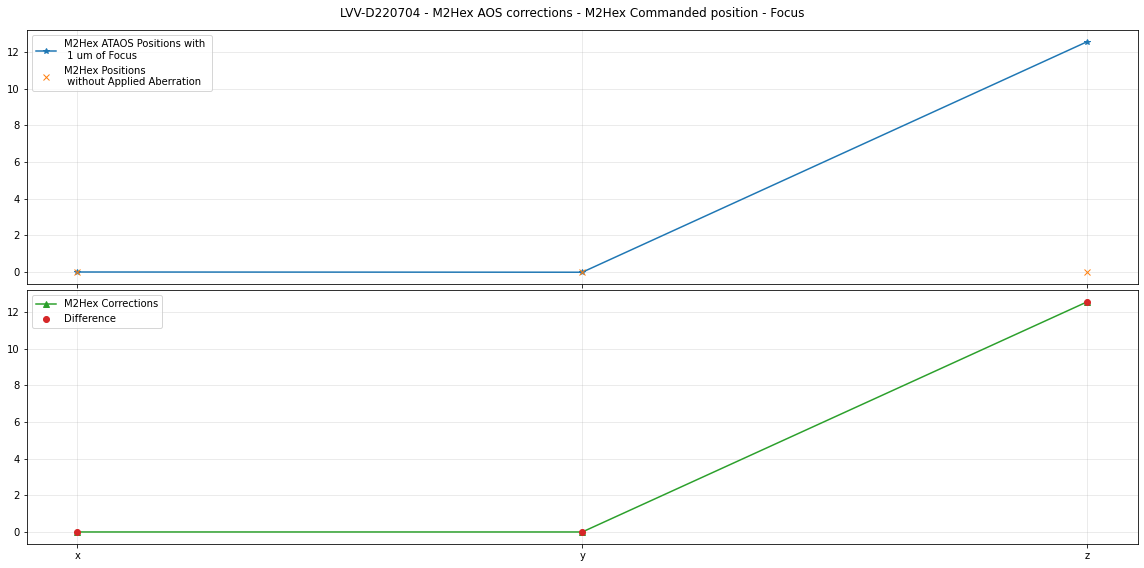

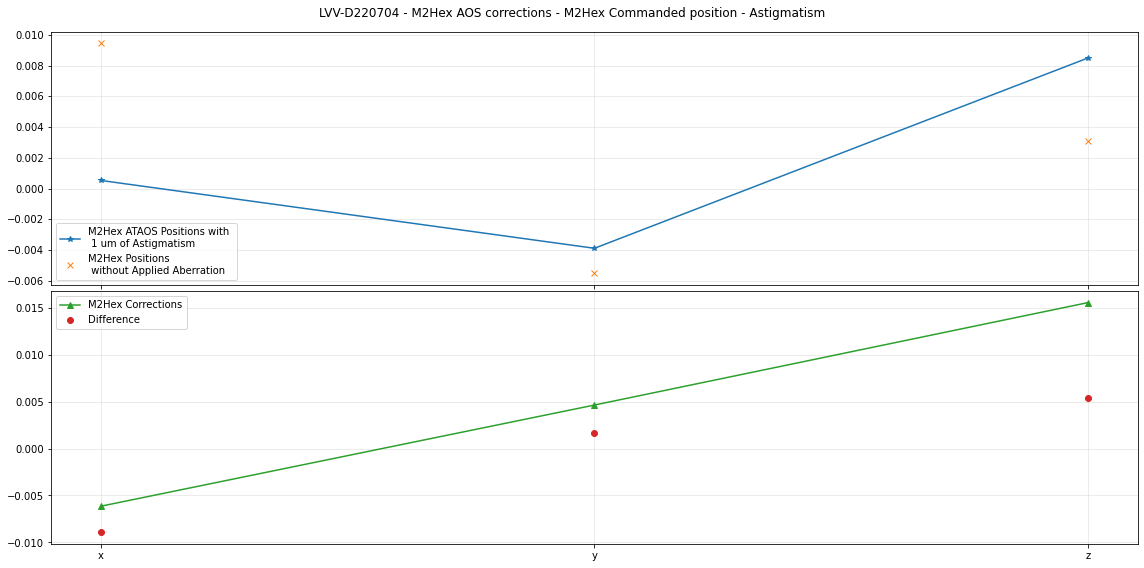

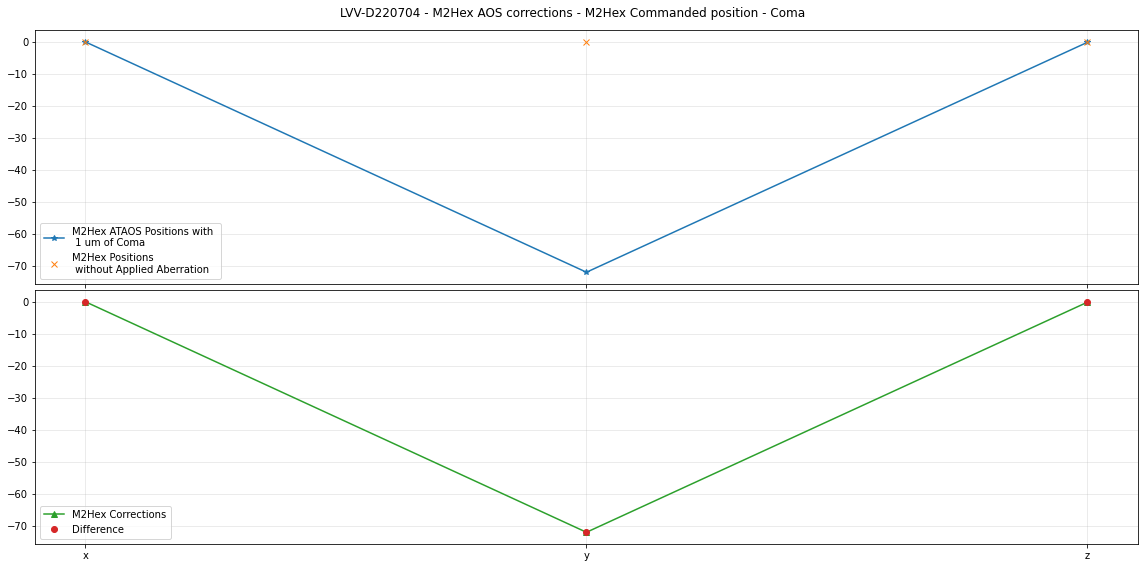

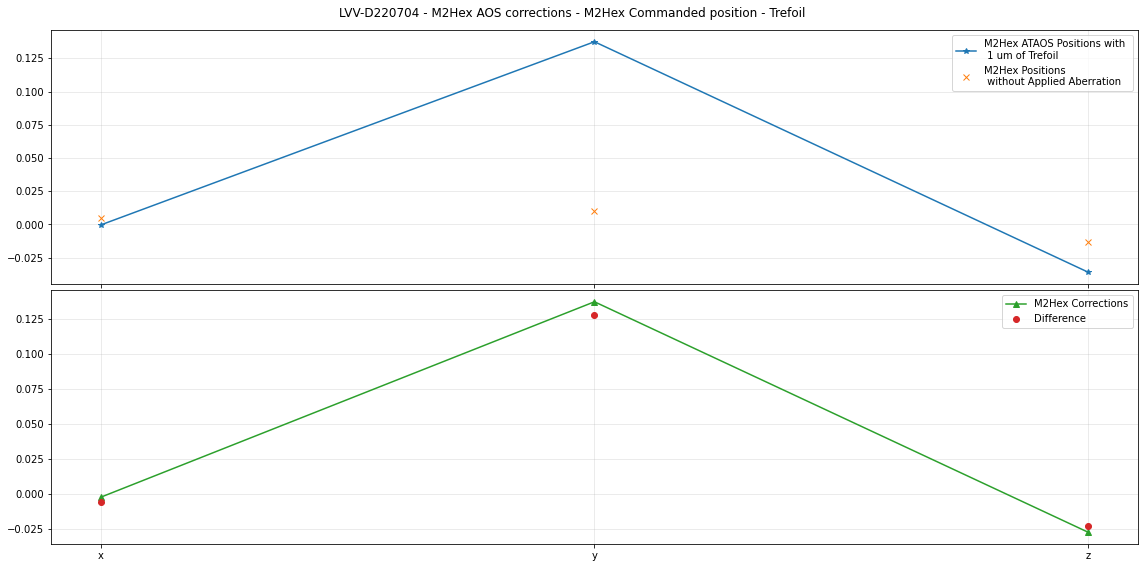

In [166]:
for track,aberr in zip(tracks,aberrations):

    fig, axs = plt.subplots(2,1, figsize=(16, 8), sharex=True)

    axs[0].plot(m2hex_withaberr.iloc[track], "C0*-", label=f"M2Hex ATAOS Positions with \n 1 um of {aberr}")
    axs[0].plot(m2hex_without.iloc[track], "C1x", label="M2Hex Positions \n without Applied Aberration")

    axs[1].plot(m2_hexapod_correction_applied_xyz.iloc[track*2], "C2^-", label="M2Hex Corrections")
    axs[1].plot(m2hex_withaberr.iloc[track]-m2hex_without.iloc[track], "C3o", label="Difference")

    for ax in axs.flat:
        ax.grid(":", alpha=0.3)
        ax.legend()
        ax.xaxis.set_ticks(np.arange(0, 3, 1))
         
    fig.suptitle(f"{test_execution} - M2Hex AOS corrections - M2Hex Commanded position - {aberr}")
    fig.tight_layout(h_pad=0.3)
    fig.patch.set_facecolor('white')   

    fig.savefig(f"plots/{test_execution}_m2M2Hexhex_vs_aos_corrections_{aberr}.png")
    plt.show()

In [167]:
# Print position differences between aberr and nonaberr tracks vs MTAOS corrections for each type of aberration

for track,aberr in zip(tracks,aberrations):
    print(f"###################    1 um of {aberr}    ###################")
    print(f"y_diff    \t \n"
          f"{m2hex_withaberr.iloc[track].y-m2hex_without.iloc[track].y:0.5f}     \n"
          f"y_corr    \t Time  ---- MTAOS correction \n"
          f"{m2_hexapod_correction_applied_xyz.iloc[track*2].y:0.5f} \t {m2_hexapod_correction_applied_xyz.index[track*2]} \n")

###################    1 um of Focus    ###################
y_diff    	 
-0.01483     
y_corr    	 Time  ---- MTAOS correction 
0.00143 	 2022-06-21 01:51:30.906000+00:00 

###################    1 um of Astigmatism    ###################
y_diff    	 
0.00161     
y_corr    	 Time  ---- MTAOS correction 
0.00463 	 2022-06-21 01:53:04.785000+00:00 

###################    1 um of Coma    ###################
y_diff    	 
-71.83324     
y_corr    	 Time  ---- MTAOS correction 
-71.85236 	 2022-06-21 01:54:14.295000+00:00 

###################    1 um of Trefoil    ###################
y_diff    	 
0.12769     
y_corr    	 Time  ---- MTAOS correction 
0.13704 	 2022-06-21 01:55:23.341000+00:00 



In [149]:
m2_hexapod_correction_applied_xyz

,x,y,z
2022-06-21 01:51:30.906000+00:00,0.002087,0.001429,12.555814
2022-06-21 01:53:03.988000+00:00,0.000000,0.000000,0.000000
2022-06-21 01:53:04.785000+00:00,-0.006144,0.004626,0.015533
2022-06-21 01:54:13.371000+00:00,0.000000,0.000000,0.000000
2022-06-21 01:54:14.295000+00:00,-0.054919,-71.852360,-0.169121
2022-06-21 01:55:22.671000+00:00,0.000000,0.000000,0.000000
2022-06-21 01:55:23.341000+00:00,-0.002115,0.137043,-0.027069
2022-06-21 01:56:32.468000+00:00,0.000000,0.000000,0.000000


## 

## Wrap up
lower m1m3,
put hardware to OFFLINE
put all simulators to STANDBY
done.

In [ ]:
# Put the telescope back to the original position
# Specially if running at TTS
await mtcs.point_azel(az=0, el=80)

In [ ]:
await mtcs.lower_m1m3()

In [ ]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mtm1m3"])

In [ ]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mtaos"])

In [ ]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mtm2"])

In [ ]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mthexapod_1"])

In [ ]:
await mtcs.set_state(state=salobj.State.STANDBY, components=["mthexapod_2"])

In [ ]:
if exec_info.loc == "summit":
    await mtcs.standby()

else:
    # Bring the system back to the original state
    await mtcs.set_state(
        state=salobj.State.ENABLED,
        components=[
            "mtm1m3", 
            "mtm2",
            "mthexapod_1",
            "mthexapod_2",
            "mtaos",
        ],
        overrides={
            "mtm1m3": "Default"
        }
    )